# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical machine learning techniques, namely:
- unsupervised link prediction based on graph-topology (Adamic Adar, Preferential Attachment, Resource-Allocation-Index, ...)
- supervised link prediction using Logistic Regression, Bagging and Boosting

### 1. Import Packages

In [2]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.modeling' from '/Users/macbookpro/Desktop/LABS/Network science/util/modeling.py'>

In [223]:
!pip3 freeze | grep -E "torch|torch-geometric|torch-sparse"

torch==2.0.0
torch-geometric==2.2.0
torch-scatter==2.1.1
torch-sparse==0.6.17
torch-spline-conv==1.2.2
torchaudio==0.10.1
torchvision==0.15.1


In [224]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
from torch_geometric.typing import SparseTensor
import util.autoencoder as autoenc

RuntimeError: 
object has no attribute sparse_csc_tensor:
  File "/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/torch_sparse/tensor.py", line 520
            value = torch.ones(self.nnz(), dtype=dtype, device=self.device())
    
        return torch.sparse_csc_tensor(colptr, row, value, self.sizes())
               ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE


In [220]:
!pip3 install torch-sparse

In [199]:
from torch_geometric.typing import SparseTensor

RuntimeError: 
object has no attribute sparse_csc_tensor:
  File "/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/torch_sparse/tensor.py", line 520
            value = torch.ones(self.nnz(), dtype=dtype, device=self.device())
    
        return torch.sparse_csc_tensor(colptr, row, value, self.sizes())
               ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE


In [200]:
!pip3 install numpy

In [179]:
!pip3 install --upgrade numba

In [166]:
!python -c "import torch; print(torch.__version__)"

2.0.0


In [176]:
!pip3 install --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.2
    Uninstalling torchvision-0.11.2:
      Successfully uninstalled torchvision-0.11.2


In [3]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling

from torch_geometric.nn import GAE, VGAE
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm

In [4]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [5]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching train data...
Enriching validation data...
Enriching test data...


In [ ]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

In [42]:
# Calculate Rooted PageRank scores for each node pair in the train dataset
alpha = 0.5  # Damping factor for PageRank calculation
rooted_pagerank_scores = []
#data = train_tf[["node1", "node2"]]
#the personalization dictionary is created with all nodes having a value of 0, except for node1, which has a value of 1. This means that the random walk will always restart at node1 when teleporting. By doing this, the resulting rooted PageRank scores capture the importance of each node in the graph with respect to node1.

# Precompute the PageRank scores (takes about 30 min)
#personalization={node: 1}
def precomputing(G, alpha):
    pagerank_scores = {node: nx.pagerank(G, alpha=alpha,personalization={node: 1}) for node in tqdm(G.nodes(), desc="Precomputing PageRank")}
    return pagerank_scores

In [10]:
def rooted_pagerank(g, node, d, epsilon = 1e-4):
    """ Returns rooted pagerank vector
    g graph
    node root
    d damping coefficient
    """
    ordered_nodes = sorted(g.nodes())
    root = ordered_nodes.index(node)
    adjecancy = nx.to_numpy_array(g, nodelist = ordered_nodes)
    m = np.copy(adjecancy)

    n = len(g)

    for i in range(len(g)):
        row_norm = np.linalg.norm(m[i], ord = 1)
        if row_norm != 0:
            m[i] = m[i] / row_norm

    m = m.transpose()

    rootvec = np.zeros(len(g))
    rootvec[root] = 1

    vect = np.random.rand(n)
    vect = vect / np.linalg.norm(vect, ord = 1)
    last_vect = np.ones(n) * 100 # to ensure that does not hit epsilon randomly in first step

    iterations = 0
    while np.linalg.norm(vect - last_vect, ord = 2) > epsilon:
        last_vect = vect.copy()
        vect = d * np.matmul(m, vect) + (1 - d) * rootvec
        iterations += 1
        #print(iterations)

    eigenvector = vect / np.linalg.norm(vect, ord = 1)

    eigen_dict = {}
    for i in range(len(ordered_nodes)):
        eigen_dict[ordered_nodes[i]] = eigenvector[i]

    #print("Bye")

    return eigen_dict
RPR ={}
for node in tqdm(G.nodes()):
    RPR[node] = rooted_pagerank(G, node, d = 0.5, epsilon = 1e-4)

100%|██████████| 3597/3597 [06:06<00:00,  9.81it/s]


In [ ]:
print(PR[510][1991])
print(train_tf.head())

In [26]:
for idx, row in train_tf[["node1", "node2"]].iterrows():
    train_tf ["RPR"] = RPR[row["node1"]][row["node2"]]
    print(RPR[row["node1"]][row["node2"]])
for idx, row in val_tf[["node1", "node2"]].iterrows():
    val_tf["rooted_pagerank"] = RPR[row['node1']][row['node2']]
for idx, row in trainval_tf[["node1", "node2"]].iterrows():
    trainval_tf["rooted_pagerank"] = RPR[row['node1']][row['node2']]
for idx, row in test_tf[["node1", "node2"]].iterrows():
    test_tf["rooted_pagerank"] = RPR[row['node1']][row['node2']]

0.3015417554958601
0.04824223735292235
0.09083527650339963
0.15175268087760288
0.007080649633658615
0.14528709614453483
1.4111279642648705e-07
0.09808718330387328
0.027085600294545664
0.03564589827637737
0.2798945963606824
0.17634782838506413
5.747642991118567e-07
0.03469898462680409
6.142039297783397e-06
1.762043436603364e-05
0.15052089111533207
3.0872871345126085e-07
4.487265287008169e-07
0.1033444181862249
0.01761503207256952
6.567359820555668e-07
0.10637810468134506
1.4667389999997323e-07
0.0551651749131914
0.010774451712142077
0.014752845136815677
0.03426547232802664
1.7291976090899388e-06
6.71323482395132e-05
1.0248122689821723e-06
2.1659224214003963e-07
4.267949819308372e-07
0.022325347678083418
6.679587231090701e-07
0.09159932893453518
4.2210646934039405e-06
0.15459250216816
0.023195838042446508
0.014543653391848562
0.06896454977704518
6.59644552119678e-08
4.518592034716114e-08
6.108973464796188e-08
2.8642285630984087e-07
0.3015435749177196
1.711859385505104e-07
0.0385888440886

In [29]:
print(RPR[510][1991])
print(train_tf.head())

0.3015417554958601
   node1  node2  y  nodeInfo_dupl  nodeInfo_diff  source_DCT  target_DCT  \
0    510   1991  1              0            9.0    0.000278    0.086763   
1   1308   2872  1              0            9.0    0.001947    0.000556   
2    100   1991  1              0           11.0    0.001112    0.086763   
5    782   2553  1              0            5.0    0.000556    0.001947   
6   3107   3307  0              0           10.0    0.002225    0.000278   

   BCT_diff  graph_distance    CNC  ...       JCC        AA    PA  CF_RA  \
0  0.407309               1  719.4  ...  0.000000  0.000000   312   0.00   
1 -0.003314               1  719.4  ...  0.000000  0.000000    14   0.00   
2  0.404920               1  720.2  ...  0.003175  0.513898  1248   0.25   
5  0.002831               1  719.4  ...  0.000000  0.000000    14   0.00   
6 -0.007766               2  360.5  ...  0.125000  1.442695     8   0.00   

     SCF_RA  CF_PA  SCF_PA    PA_log  rooted_pagerank           RPR

In [28]:
# Compute PageRank scores for the entire graph with default personalization (None)
pagerank_scores = nx.pagerank(G, alpha=alpha, personalization = None)

# Store the PageRank scores in a dictionary using tqdm
pagerank_scores_dict = {}
for node in tqdm(G.nodes(), desc="Precomputing PageRank"):
    pagerank_scores_dict[node] = pagerank_scores[node]

Precomputing PageRank: 100%|██████████| 3597/3597 [00:00<00:00, 2731651.55it/s]


In [25]:
print(pagerank_scores_dict)
pagerank_scores_dict[17][2588]


{510: 0.00011854263146797716, 1991: 0.0329630259196682, 1308: 0.0005470881185708515, 2872: 0.0003579519102834942, 100: 0.0003169517736864451, 466: 0.0005353296419902413, 1221: 0.0013232237143704086, 723: 0.0001815830778918198, 2846: 0.0011174415867074266, 782: 0.00023402249164708818, 2553: 0.0007948259431519803, 599: 0.0001963459372162504, 3231: 0.0003773690068763991, 2228: 0.000418405137245699, 3173: 0.00016061039333753368, 1272: 0.0007210101271170744, 1639: 0.001581986820544412, 900: 0.0006066249131872278, 2875: 0.00039095948729104895, 2428: 0.00010744025628564653, 3449: 0.0023234329708266954, 292: 0.0005036275238664682, 337: 0.0007901890055492317, 2243: 0.00022441947488820694, 2688: 0.00022441947488820694, 764: 0.0007156494887080119, 1833: 0.00022672010239655515, 38: 0.0002624756736796367, 2390: 0.00015339833264991056, 676: 0.0007560131425224165, 2764: 0.00028305059039930537, 3421: 0.0002465072959167739, 2263: 0.0002536483537782145, 2733: 0.00040634589445089943, 3481: 0.002892285773

TypeError: 'float' object is not subscriptable

In [28]:
def compute_rooted_pagerank_score(data, pagerank_scores):
    rooted_pagerank_scores = []
    # Calculate the rooted PageRank scores
    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Processing rows"):
        rooted_pagerank_score = pagerank_scores[row["node1"]][row["node2"]]
        rooted_pagerank_scores.append(rooted_pagerank_score)
    return rooted_pagerank_scores

train_scores = compute_rooted_pagerank_score(train_tf[["node1", "node2"]], RPR)
val_scores = compute_rooted_pagerank_score(val_tf[["node1", "node2"]], RPR)
trainval_scores = compute_rooted_pagerank_score(trainval_tf[["node1", "node2"]], RPR)
test_scores = compute_rooted_pagerank_score(test_tf[["node1", "node2"]], RPR)
train_tf["rooted_pagerank"] = train_scores
val_tf["rooted_pagerank"] = val_scores
trainval_tf["rooted_pagerank"] = trainval_scores
test_tf["rooted_pagerank"] = test_scores

Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 32501.10it/s]


In [95]:
alpha = 0.4
#alpha 0.5 and radomforest -> 0.74053
#alpha 0.85 and randomforest -> 0.72808
#alpha 0.3 and randomforest -> 0.7426
#alpha 0.3 and logit -> 0.75418 0: 2370 1: 1128
#alpha 0.15 and logit -> 0.7517 0: 2386 1: 1112
#PR enriched alpha = 0.15 and logit -> 0.7559 0: 2326 1: 1172
#PR enriched alpha = 0.3 and logit -> 0.75759 0: 2302 1: 1196
#PR enriched alpha = 0.5 and logit -> 0.75217 0: 2357 1: 1141
#PR enriched alpha = 0.4 and logit -> 0: 2341 1: 1157

pagerank_scores = nx.pagerank(G, alpha=alpha)
def pagerank_score(data, pagerank_scores = pagerank_scores):
    PR1 = []
    PR2 = []
    # Calculate the rooted PageRank scores
    for idx, row in data.iterrows():
        pr1 = (pagerank_scores[row["node1"]]+pagerank_scores[row["node2"]])/2
        pr2 = (pagerank_scores[row["node1"]] - pagerank_scores[row["node2"]])**2
        PR1.append(pr1)
        PR2.append(pr2)
    return PR1, PR2

train_scores_1, train_scores_2 = pagerank_score(train_tf[["node1", "node2"]])
val_scores_1, val_scores_2 = pagerank_score(val_tf[["node1", "node2"]])
trainval_scores_1, trainval_scores_2 = pagerank_score(trainval_tf[["node1", "node2"]])
test_scores_1, test_scores_2 = pagerank_score(test_tf[["node1", "node2"]])
train_tf["PR1"], train_tf["PR2"] = train_scores_1, train_scores_2
val_tf["PR1"], val_tf["PR2"] = val_scores_1, val_scores_2
trainval_tf["PR1"], trainval_tf["PR2"] = trainval_scores_1, trainval_scores_2
test_tf["PR1"], test_tf["PR2"] = test_scores_1, test_scores_2
print("done")

print((pagerank_scores[510]+pagerank_scores[1991])/2, (pagerank_scores[510] - pagerank_scores[1991])**2)
print((pagerank_scores[1308]+pagerank_scores[2872])/2)
print((pagerank_scores[3107]+pagerank_scores[3307])/2)
print(train_tf[["PR1", "PR2"]].head())

done
0.010376081555342845 0.0004150886560575146
0.00036421185639846584
0.0003735510302186134
        PR1           PR2
0  0.010376  4.150887e-04
1  0.000364  5.593700e-09
2  0.010412  4.121456e-04
5  0.000403  9.054023e-08
6  0.000374  9.216293e-08


In [96]:
# Train the model using the features, including the 'rooted_pagerank' column
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# Prepare the feature matrix and target variable
#'nodeInfo_dupl', 'nodeInfo_diff', 'source_DCT', 'target_DCT', 'BCT_diff', 'graph_distance', 'CNC', 'RA', 'JCC', 'AA', 'PA', 'CF_RA', 'SCF_RA', 'CF_PA', 'SCF_PA', 'PA_log', 'rooted_pagerank'

features = [
    'nodeInfo_dupl', 'nodeInfo_diff', 'source_DCT', 'target_DCT', 'BCT_diff',
    'graph_distance', 'CNC', 'RA', 'JCC', 'AA', 'PA', 'CF_RA', 'SCF_RA',
    'CF_PA', 'SCF_PA', 'PA_log', 'PR1', 'PR2'
]

trainval = pd.concat([train_tf, val_tf], ignore_index=True)

X_train = train_tf[['node1', 'node2'] + features]
y_train = train_tf["y"]

X_val = val_tf[['node1', 'node2'] + features]
y_val = val_tf["y"]


X_trainval = trainval[["node1","node2"] + features]
y_trainval = trainval["y"]

X_test = test_tf[["node1","node2"] + features]

# Train the random forest classifier
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = LogisticRegression(penalty='l2', solver='liblinear')
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
#Evaluate the model performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

'''
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
'''

print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_pred))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      1050
           1       0.97      0.06      0.12      1043

    accuracy                           0.53      2093
   macro avg       0.74      0.53      0.40      2093
weighted avg       0.74      0.53      0.40      2093



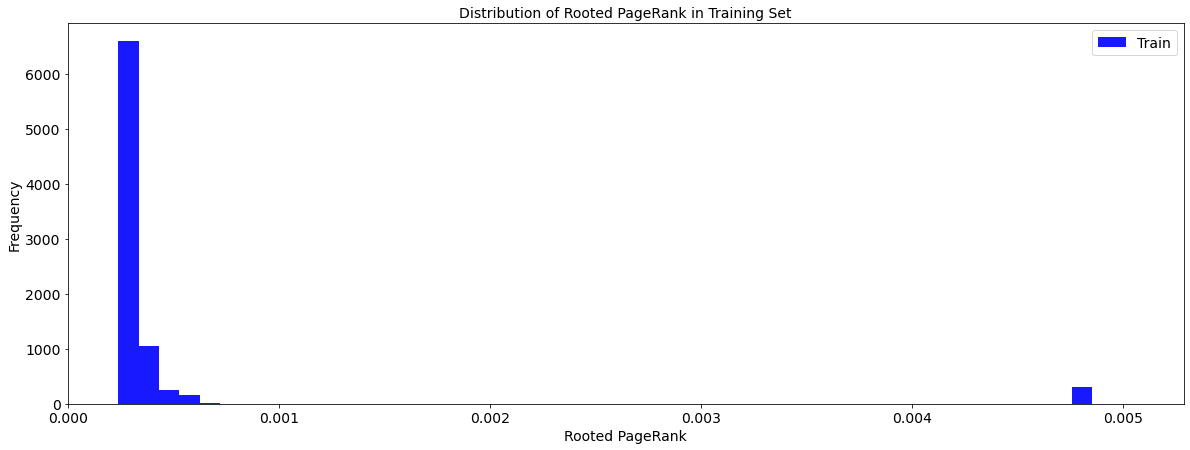

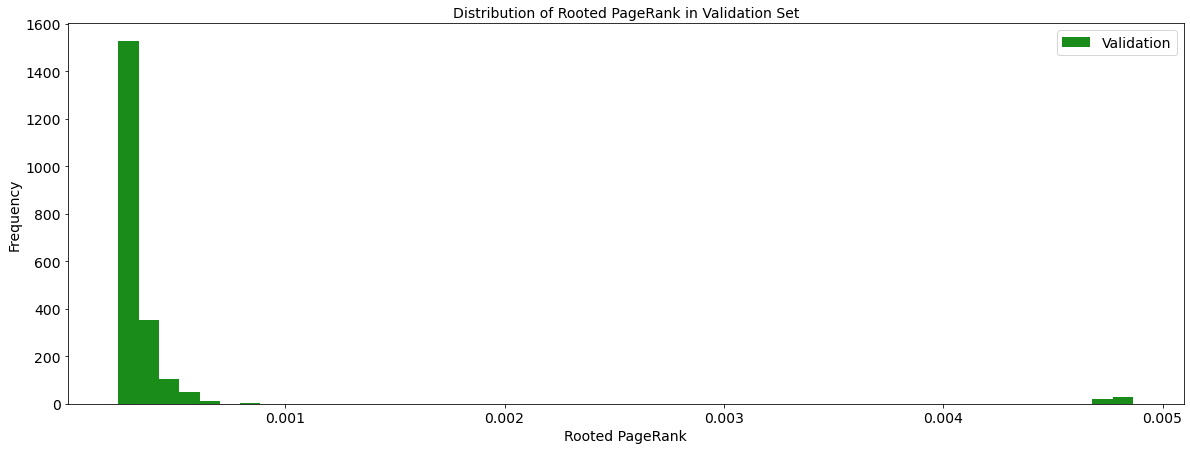

Training set summary statistics:
count    8.372000e+03
mean     6.820763e-02
std      9.799896e-02
min      6.876855e-09
25%      4.684310e-07
50%      3.026280e-03
75%      1.010913e-01
max      3.192621e-01
Name: rooted_pagerank, dtype: float64

Validation set summary statistics:
count    2.093000e+03
mean     3.423032e-02
std      4.450741e-02
min      9.220043e-09
25%      4.438422e-07
50%      4.391994e-03
75%      5.984520e-02
max      1.936511e-01
Name: rooted_pagerank, dtype: float64


In [93]:
font = 14
# Histogram for the training set
plt.figure(figsize=(20, 7))
plt.hist(train_tf["PR"], bins=50, alpha=0.9, color="blue", label="Train")
plt.xlabel("Rooted PageRank", fontsize = font)
plt.ylabel("Frequency", fontsize = font)
plt.xticks(fontsize = font)
plt.yticks(fontsize = font)
plt.title("Distribution of Rooted PageRank in Training Set", fontsize = font)
plt.legend(fontsize = font)
plt.show()


# Histogram for the validation set
plt.figure(figsize=(20, 7))
plt.hist(val_tf["PR"], bins=50, alpha=0.9, color="green", label="Validation")
plt.xlabel("Rooted PageRank", fontsize = font)
plt.ylabel("Frequency", fontsize = font)
plt.xticks(fontsize = font)
plt.yticks(fontsize = font)
plt.title("Distribution of Rooted PageRank in Validation Set", fontsize = font)
plt.legend(fontsize = font)
plt.show()

# Summary statistics for the training set
train_summary = train_tf["rooted_pagerank"].describe()
print("Training set summary statistics:")
print(train_summary)

# Summary statistics for the validation set
val_summary = val_tf["rooted_pagerank"].describe()
print("\nValidation set summary statistics:")
print(val_summary)

In [97]:
# Train on the whole training + validation set
clf.fit(X_trainval, y_trainval)
# Make predictions on the test set
print(len(X_test))
y_pred = clf.predict(X_test)
save_test = modeling.save_test_preds(test, test_tf, y_pred)
save_test.value_counts()


3481


Predicted
0            2341
1            1157
dtype: int64

In [45]:
alphas = [0.15, 0.25, 0.35, 0.75]
for alpha in alphas:
    pagerank_scores = precomputing(G, alpha)
    train_scores = compute_rooted_pagerank_score(train_tf[["node1", "node2"]], pagerank_scores)
    val_scores = compute_rooted_pagerank_score(val_tf[["node1", "node2"]], pagerank_scores)
    trainval_scores = compute_rooted_pagerank_score(trainval_tf[["node1", "node2"]], pagerank_scores)
    test_scores = compute_rooted_pagerank_score(test_tf[["node1", "node2"]], pagerank_scores)
    train_tf["rooted_pagerank"] = train_scores
    val_tf["rooted_pagerank"] = val_scores
    trainval_tf["rooted_pagerank"] = trainval_scores
    test_tf["rooted_pagerank"] = test_scores
    features = [
    'nodeInfo_dupl', 'nodeInfo_diff', 'source_DCT', 'target_DCT', 'BCT_diff',
    'graph_distance', 'CNC', 'RA', 'JCC', 'AA', 'PA', 'CF_RA', 'SCF_RA',
    'CF_PA', 'SCF_PA', 'PA_log', 'rooted_pagerank'
    ]

    trainval = pd.concat([train_tf, val_tf], ignore_index=True)

    X_train = train_tf[['node1', 'node2'] + features]
    y_train = train_tf["y"]

    X_val = val_tf[['node1', 'node2'] + features]
    y_val = val_tf["y"]


    X_trainval = trainval[["node1","node2"] + features]
    y_trainval = trainval["y"]

    X_test = test_tf[["node1","node2"] + features]

    # Train the random forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    #clf = LogisticRegression(penalty='l2', C=1.5, solver='liblinear')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    # Evaluate the model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    '''
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    '''

    print(f'Train performance with alpha: {alpha}')
    print('-------------------------------------------------------')
    print(classification_report(y_val, y_pred))
    # Train on the whole training + validation set
    clf.fit(X_trainval, y_trainval)
    # Make predictions on the test set
    print(len(X_test))
    y_pred = clf.predict(X_test)
    save_test = modeling.save_test_preds(test, test_tf, y_pred)
    print(f'results with alpha: {alpha}')
    save_test.value_counts()

Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 33184.63it/s]
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Train performance with alpha: 0.25
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1043

    accuracy                           0.50      2093
   macro avg       0.25      0.50      0.33      2093
weighted avg       0.25      0.50      0.34      2093



Precomputing PageRank:   0%|          | 0/3597 [00:00<?, ?it/s]

3481
results with alpha: 0.25


Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 32560.75it/s]
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Train performance with alpha: 0.35
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1043

    accuracy                           0.50      2093
   macro avg       0.25      0.50      0.33      2093
weighted avg       0.25      0.50      0.34      2093



Precomputing PageRank:   0%|          | 0/3597 [00:00<?, ?it/s]

3481
results with alpha: 0.35


Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 29214.30it/s]
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Train performance with alpha: 0.75
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1043

    accuracy                           0.50      2093
   macro avg       0.25      0.50      0.33      2093
weighted avg       0.25      0.50      0.34      2093

3481
results with alpha: 0.75


Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 28503.83it/s]
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Train performance with alpha: 0.15
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1043

    accuracy                           0.50      2093
   macro avg       0.25      0.50      0.33      2093
weighted avg       0.25      0.50      0.34      2093



Precomputing PageRank:   0%|          | 0/3597 [00:00<?, ?it/s]

3481
results with alpha: 0.15


Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 29644.70it/s]
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Train performance with alpha: 0.25
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1043

    accuracy                           0.50      2093
   macro avg       0.25      0.50      0.33      2093
weighted avg       0.25      0.50      0.34      2093



Precomputing PageRank:   0%|          | 0/3597 [00:00<?, ?it/s]

3481
results with alpha: 0.25


Processing rows: 100%|██████████| 3481/3481 [00:00<00:00, 33715.21it/s]
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Train performance with alpha: 0.35
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1043

    accuracy                           0.50      2093
   macro avg       0.25      0.50      0.33      2093
weighted avg       0.25      0.50      0.34      2093



Precomputing PageRank:   0%|          | 0/3597 [00:00<?, ?it/s]

3481
results with alpha: 0.35


Precomputing PageRank:   9%|▉         | 334/3597 [01:44<18:03,  3.01it/s]

KeyboardInterrupt: 

In [47]:
print(train_tf["rooted_pagerank"])

0        2.480270e-01
1        3.846475e-02
2        6.979316e-02
5        1.241759e-01
6        4.013662e-03
             ...     
10491    1.644864e-07
10492    2.709174e-07
10493    3.534497e-02
10494    5.274342e-06
10495    1.064375e-07
Name: rooted_pagerank, Length: 8372, dtype: float64


In [74]:
args_list = [(idx, row, G, alpha) for idx, row in train_data.iterrows()]
print(len(args_list))
args_list1 = args_list[0:2093]
args_list2 = args_list[2093:4186]
args_list3 = args_list[4186:6279]
args_list4 = args_list[6279:8372]
print(len(args_list1))
print(len(args_list2))
print(len(args_list3))
print(len(args_list4))
args_list = [args_list1, args_list2, args_list3, args_list4]
print(len(args_list))

8372
2093
2093
2093
2093
4


TypeError: plot() got an unexpected keyword argument 'text_kw'

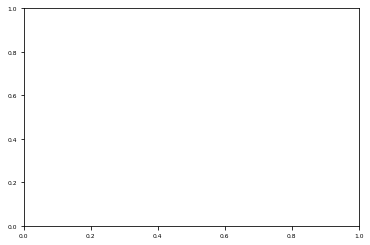

In [144]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

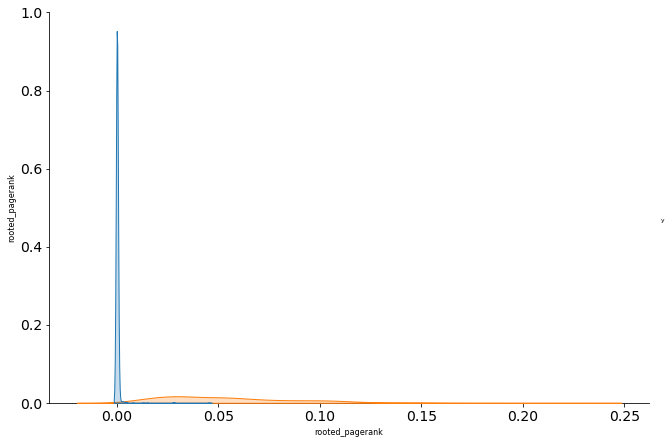

In [170]:
pairplot = sns.pairplot(val_tf[["rooted_pagerank", "y"]], hue="y", height=6, aspect=1.5)

# Set fontsize for x-axis and y-axis ticks
fontsize = 12

for ax in pairplot.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=font)

plt.show()

### 3. Unsupervised Link Prediction

TODO: try to implement other classical link prediction algos (see lecture 3, Liben-Nowell and Kleinberg Paper in 2003)
- weighted Katz
- Katz clustering
- low-rank inner product
- rooted PageRank
- unseen bigrams
- SimRank
- hitting time

regarding dist: cut off should NOT be mean (only for classical link prediction algos!) --> write a function that finds best cutoff point based on validation set for "sim" and "dist" features that come from autoencoder

In [29]:
# which cols we want to use for link prediction
cols = ["sim", "CNC", "RA", "JCC", "AA", "PA"] # "graph_distance"

# training data
X_train_lp = X_train[cols]
X_train_lp = X_train_lp.rank(pct = True)
#X_train_lp["graph_distance"] = 1 - X_train_lp["graph_distance"] # graph distance: the lower the better!
y_train_hat = (X_train_lp > 0.9).any(axis = 1).astype(int)
y_train_hat.loc[y_train_hat == 0] = (X_train_lp.loc[y_train_hat == 0].mean(axis = 1) > 0.5).astype(int)

# validation data
X_val_lp = X_val[cols]
X_val_lp = X_val_lp.rank(pct = True)
#X_val_lp["graph_distance"] = 1 - X_val_lp["graph_distance"] # graph distance: the lower the better!
y_val_hat = (X_val_lp > 0.9).any(axis = 1).astype(int)
y_val_hat.loc[y_val_hat == 0] = (X_val_lp.loc[y_val_hat == 0].mean(axis = 1) > 0.5).astype(int)

# test data
X_test_lp = X_test[cols]
X_test_lp = X_test_lp.rank(pct = True)
#X_test_lp["graph_distance"] = 1 - X_test_lp["graph_distance"] # graph distance: the lower the better!
y_test_hat = (X_test_lp.mean(axis = 1) > 0.5).astype(int)

In [30]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4198
           1       0.86      0.86      0.86      4174

    accuracy                           0.86      8372
   macro avg       0.86      0.86      0.86      8372
weighted avg       0.86      0.86      0.86      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1050
           1       0.80      0.73      0.76      1043

    accuracy                           0.77      2093
   macro avg       0.78      0.77      0.77      2093
weighted avg       0.78      0.77      0.77      2093

Roc_auc score
-------------------------------------------------------
0.7738702460850111

Confusion matrix
-------------------------------------------------------
[[856 194]
 [279 764]]


In [31]:
# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)

In [32]:
# look at predicted labels
save_test.value_counts()

Predicted
0            1799
1            1699
dtype: int64

### 4. Supervised Link Prediction